# Imports

In [ ]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import time

import networkx as nx
from networkx.algorithms import community

import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import jaccard_score
import math
from itertools import cycle
import yaml

seed_value=123

# Load Dataset from CSV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def graph_info(G):
    print(f"Type : {type(G)}")
    print(f"Number of nodes : {len(list(G.nodes))}")
    print(f"Number of edges : {len(list(G.edges))}")

sigmoid = lambda x: 1 / (1 + math.exp(-x))

def extract_date(filename):
    parts = os.path.splitext(filename)[0].split('-')
    if len(parts) == 3:
        year, month, day = map(int, parts)
        return f"{year:04d}-{month:02d}-{day:02d}"
    else:
        return '9999-99-99'  # Default for files without a date

In [ ]:
data_path = "/content/drive/MyDrive/Master/M2 France/Data Mining/Project/data/data/data/networks/"

# empty directed graph
graph = nx.MultiDiGraph()

unique_dates = []

# List all files in the directory
files = os.listdir(data_path)

# Sort files based on the extracted date
sorted_files = sorted(files, key=extract_date)

for dates in tqdm(sorted_files):
    # get file name and date
    file_path = os.path.join(data_path, dates)
    date = file_path.split('/')[-1][:-4].split('-')
    date = datetime(int(date[0]), int(date[1]), int(date[2])).strftime("%Y-%m-%d")
    month = int(date[1]) + 12 * (int(date[2])==2016) + 24 * (int(date[2])==2017)


    unique_dates.append(date)
    # load file
    df = pd.read_csv(file_path)

    # adding nodes and edges to the graph
    for index, row in df.iterrows():
        the_source = row['Source']
        the_target = row['Target']
        value = row['value']
        nb_transactions = row['nb_transactions']

        # add node (wont be added if already in graph)
        graph.add_node(the_source)
        graph.add_node(the_target)

        # Add directed edge from source to target
        graph.add_edge(the_source, the_target, value=value, nb_transactions=nb_transactions, date=date, month=month)

In [ ]:
unique_dates = sorted(unique_dates)
unique_dates[:5]

# One DF to rule them all

In [ ]:
###############################################################################
####### Code to create one data frame from all the data with grouped by #######
####### using windows of 60 days (maybe we should use the last group)   #######
###############################################################################
data_path = "/content/drive/MyDrive/Master/M2 France/Data Mining/Project/data/data/data/networks/"

# empty directed graph
graph = nx.MultiDiGraph()

unique_dates = []

# List all files in the directory
files = os.listdir(data_path)

# Sort files based on the extracted date
sorted_files = sorted(files, key=extract_date)

count_id =0
dataframes_shapes = []
df_list = []
for file in sorted_files:
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path)
    df['date']=extract_date(file)
    df['date'] = pd.to_datetime(df['date'])
    df['Month'] = df['date'].dt.strftime('%m')
    df['Year'] = df['date'].dt.strftime('%Y')
    df['ID'] = count_id // 30
    dataframes_shapes.append(df.shape)
    count_id+=1
    df_list.append(df)

# Create the df
df = pd.concat(df_list)

# Group by 'Source', 'Target', and 'ID, and sum the 'value' column within each group
grouped_df = df.groupby(['Source', 'Target', 'ID'])['value'].sum().reset_index()

# Rename the sum column to 'Total_value'
grouped_df_Total_value = grouped_df.rename(columns={'value': 'Total_value'})

grouped_df = df.groupby(['Source', 'Target', 'ID'])['nb_transactions'].sum().reset_index()

# Rename the sum column to 'Total_nb_transactions'
grouped_df_Total_nb_transactions = grouped_df.rename(columns={'nb_transactions': 'Total_nb_transactions'})



# Group by 'Category', 'Subcategory', and 'Type', and count occurrences within each group
grouped_df_Count = df.groupby(['Source', 'Target', 'ID']).size().reset_index(name='Count')

df_merged = pd.merge(grouped_df_Total_value, grouped_df_Total_nb_transactions, on=['Source', 'Target', 'ID'], how='left')
df_merged = pd.merge(df_merged, grouped_df_Count, on=['Source', 'Target', 'ID'], how='left')
df_merged.head()

final_df = df_merged.sort_values(by=['Source','ID'], ascending=True)
final_df.head()

,Source,Target,ID,Total_value,Total_nb_transactions,Count
139,0,10399,0,46122078,3,3
206,0,107,0,3281071,3,3
336,0,1095,0,49586631,19,12
374,0,1103,0,157608246,5,5
462,0,1138,0,148084826,5,5


# Create graph for each month

In [ ]:
def create_graph(df):
  unique_values_col_ID = df['ID'].unique()

  dict_graph={}
  for id in tqdm(unique_values_col_ID[:-1]):
    df_copy=df[df['ID'] == id]
    graph = nx.MultiDiGraph()

    for index, row in df_copy.iterrows():
      the_source = row['Source']
      the_target = row['Target']
      value = row['Total_value']
      nb_transactions = row['Total_nb_transactions']
      count = row['Count']

      # add node (wont be added if already in graph)
      graph.add_node(the_source)
      graph.add_node(the_target)

      # Add directed edge from source to target
      graph.add_edge(the_source, the_target, value=value, nb_transactions=nb_transactions,count=count)

    dict_graph[id]=graph

  return dict_graph

In [ ]:
dict_graph=create_graph(final_df)

100%|██████████| 30/30 [02:50<00:00,  5.67s/it]


# Load Dataset from graphml

In [ ]:
data_path_save_load = "/content/drive/MyDrive/Master/M2 France/Data Mining/Project/data/data/data/"

In [ ]:
graphml_file = "graph.graphml"
graph = nx.read_graphml(data_path_save_load + graphml_file)

data_path = "/content/drive/MyDrive/Master/M2 France/Data Mining/Project/data/data/data/networks/"
unique_dates = []

for file_name in tqdm(os.listdir(data_path)):
    # get file name and date
    file_path = os.path.join(data_path, file_name)
    date = file_path.split('/')[-1][:-4].split('-')
    date = datetime(int(date[0]), int(date[1]), int(date[2])).strftime("%Y-%m-%d")

    unique_dates.append(date)

unique_dates = sorted(unique_dates)
unique_dates[:5]

100%|██████████| 912/912 [00:00<00:00, 130131.15it/s]


['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04', '2015-01-05']

##Load communities

In [ ]:
file_path_louvain = os.path.join(data_path_save_load, "communities_louvain.yml")
file_path_label = os.path.join(data_path_save_load, "communities_label.yml")
file_path_greedy = os.path.join(data_path_save_load, "communities_greedy.yml")
between = os.path.join(data_path_save_load, "betweenness.yml")
modularity_label = os.path.join(data_path_save_load, "modularity_label.yml")
modularity_greedy = os.path.join(data_path_save_load, "modularity_greedy.yml")
modularity_louvain = os.path.join(data_path_save_load, "modularity_louvain.yml")

In [ ]:
file_path_label

'/content/drive/MyDrive/Master/M2 France/Data Mining/Project/data/data/data/communities_label.yml'

In [ ]:
with open(file_path_louvain, 'r') as file:
    communities_louvain = yaml.load(file, Loader=yaml.FullLoader)

In [ ]:
for i in sorted(communities_louvain[18],key=len,reverse=True):
  print(len(i))

4231
2946
531
89
54
13
6
6
6
4
4
3
3
2
2
2
2
2
2
2
2
2
2


In [ ]:
with open(file_path_label, 'r') as file:
    communities_label = yaml.load(file, Loader=yaml.FullLoader)

In [ ]:
for i in sorted(communities_label[18],key=len,reverse=True):
  print(len(i))

7569
44
36
35
23
21
8
5
5
5
4
4
4
4
4
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [ ]:
with open("communities_greedy_copy.yml", 'r') as file:
    communities_greedy = yaml.safe_load(file)

In [ ]:
for i in sorted(communities_greedy[18],key=len,reverse=True):
  print(len(i))

4716
2464
563
36
23
20
9
6
6
5
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


## Save all graph

In [ ]:
for i in tqdm(range(len(dict_graph))):

  community_dict = {}
  for community_id, community in enumerate(communities_louvain[i]):
      for node in community:
          community_dict[node] = community_id

  nx.set_node_attributes(dict_graph[i], community_dict, 'community_id')
  nx.write_gexf(dict_graph[i], "/content/drive/MyDrive/Master/M2 France/Data Mining/Project/data/data/data/graphID"+str(i)+"_louvain.gexf")

100%|██████████| 30/30 [01:52<00:00,  3.74s/it]


In [ ]:
for i in tqdm(range(len(dict_graph))):

  community_dict = {}
  for community_id, community in enumerate(communities_greedy[i]):
      for node in community:
          community_dict[node] = community_id

  nx.set_node_attributes(dict_graph[i], community_dict, 'community_id')
  nx.write_gexf(dict_graph[i], "/content/drive/MyDrive/Master/M2 France/Data Mining/Project/data/data/data/graphID"+str(i)+"_greedy.gexf")

100%|██████████| 30/30 [01:55<00:00,  3.85s/it]


In [ ]:
for i in tqdm(range(len(dict_graph))):

  community_dict = {}
  for community_id, community in enumerate(communities_label[i]):
      for node in community:
          community_dict[node] = community_id

  nx.set_node_attributes(dict_graph[i], community_dict, 'community_id')
  nx.write_gexf(dict_graph[i], "/content/drive/MyDrive/Master/M2 France/Data Mining/Project/data/data/data/graphID"+str(i)+"_label.gexf")

100%|██████████| 30/30 [01:59<00:00,  3.99s/it]


## Save subgraph graph

In [ ]:
for i in tqdm(range(len(dict_graph))):
  partition = {node: community_id for community_id, nodes in enumerate(communities_louvain[i]) for node in nodes}

  filtered_communities_id = [community_id for community_id, nodes in enumerate(communities_louvain[i]) if len(nodes) > 5]

  filtered_communities = [nodes for community_id, nodes in enumerate(communities_louvain[i]) if len(nodes) > 5]

  # Create a subgraph containing only nodes from the filtered communities
  subgraph_nodes = [node for node, community_id in partition.items() if community_id in filtered_communities_id]
  subgraph = dict_graph[i].subgraph(subgraph_nodes)

  community_dict = {}
  for community_id, community in enumerate(filtered_communities):
      for node in community:
          community_dict[node] = community_id

  nx.set_node_attributes(subgraph, community_dict, 'community_id')
  nx.write_gexf(subgraph, "/content/drive/MyDrive/Master/M2 France/Data Mining/Project/data/data/data/subgraphID"+str(i)+"_louvain.gexf")

100%|██████████| 30/30 [02:27<00:00,  4.93s/it]


In [ ]:
for i in tqdm(range(len(dict_graph))):
  partition = {node: community_id for community_id, nodes in enumerate(communities_greedy[i]) for node in nodes}

  filtered_communities_id = [community_id for community_id, nodes in enumerate(communities_greedy[i]) if len(nodes) > 5]

  filtered_communities = [nodes for community_id, nodes in enumerate(communities_greedy[i]) if len(nodes) > 5]


  # Create a subgraph containing only nodes from the filtered communities
  subgraph_nodes = [node for node, community_id in partition.items() if community_id in filtered_communities_id]
  subgraph = dict_graph[i].subgraph(subgraph_nodes)

  community_dict = {}
  for community_id, community in enumerate(filtered_communities):
      for node in community:
          community_dict[node] = community_id

  nx.set_node_attributes(subgraph, community_dict, 'community_id')
  nx.write_gexf(subgraph, "/content/drive/MyDrive/Master/M2 France/Data Mining/Project/data/data/data/subgraphID"+str(i)+"_greedy.gexf")

100%|██████████| 30/30 [02:24<00:00,  4.83s/it]


In [ ]:
for i in tqdm(range(len(dict_graph))):
  partition = {node: community_id for community_id, nodes in enumerate(communities_label[i]) for node in nodes}

  filtered_communities_id = [community_id for community_id, nodes in enumerate(communities_label[i]) if len(nodes) > 5]

  filtered_communities = [nodes for community_id, nodes in enumerate(communities_label[i]) if len(nodes) > 5]

  # Create a subgraph containing only nodes from the filtered communities
  subgraph_nodes = [node for node, community_id in partition.items() if community_id in filtered_communities_id]
  subgraph = dict_graph[i].subgraph(subgraph_nodes)

  community_dict = {}
  for community_id, community in enumerate(filtered_communities):
      for node in community:
          community_dict[node] = community_id

  nx.set_node_attributes(subgraph, community_dict, 'community_id')
  nx.write_gexf(subgraph, "/content/drive/MyDrive/Master/M2 France/Data Mining/Project/data/data/data/subgraphID"+str(i)+"_label.gexf")

100%|██████████| 30/30 [02:23<00:00,  4.77s/it]


##Function

In [ ]:
def select_graph(graph_all,date):
  edges_to_remove = []
  graph = graph_all.copy()
  for edge in graph.edges(data=True):
      if (edge[2]["date"]!= date):
          #print(f"to remove : {(edge[0], edge[1])}")
          edges_to_remove.append((edge[0], edge[1]))

  for rm_edge in edges_to_remove:
    graph.remove_edge(rm_edge[0], rm_edge[1])

  isolated_nodes = list(nx.isolates(graph))

  graph.remove_nodes_from(isolated_nodes)

  return graph

In [ ]:
def plot_graph(G):
  betweenness_centrality = nx.betweenness_centrality(G)

  sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1],reverse=True)


  for index, (key, value) in enumerate(sorted_betweenness_centrality):
    if index<10:
      betweenness_centrality[key]=(1,value)
    else:
      betweenness_centrality[key]=(0,value)

  node_sizes = [20+centrality*80 for centrality,_ in betweenness_centrality.values()]

  edge_weights = [data['value'] for _, _, data in G.edges(data=True)]

  # Normalize edge weights to be in the range [0, 1] (optional)
  normalized_edge_weights = np.log2(edge_weights)
  edge_widths = [weight * 0.01 for weight in normalized_edge_weights]

  #node_labels = {key: str(key) for key, value in betweenness_centrality.items() if value[0]==1}

  plt.figure(figsize=(12, 10))

  pos = nx.spring_layout(G)
  nx.draw(G, pos, node_color='skyblue', node_size=node_sizes,
          font_size=2, font_color='black', font_weight='bold', edge_color='gray', width=edge_widths,alpha=0.1, arrows=False)

  # Show the plot
  plt.show()

In [ ]:
def find_comunities(dict_G):
  communities_louvain={}
  communities_girvan_newman={}
  communities_label={}
  betweenness={}
  for i in tqdm(range(len(dict_G))):
    betweenness[i] = nx.betweenness_centrality(dict_G[i])
    communities_louvain[i] = list(nx.community.louvain_communities(dict_G[i].to_undirected(),seed=seed_value))
    communities_girvan_newman[i] = list(nx.community.girvan_newman(dict_G[i].to_undirected()))
    communities_label[i] = list(nx.community.label_propagation.label_propagation_communities(dict_G[i].to_undirected()))

  return communities_louvain,communities_girvan_newman,communities_label,betweenness

In [ ]:
def save_graph_betweenness_centrality(dict_G):
  betweenness={}
  for i in tqdm(range(len(dict_G))):
    betweenness[i] = nx.betweenness_centrality(dict_G[i].to_undirected())
  return betweenness

In [ ]:
def plot_graph_with_community(G,community_method):

  if(community_method=="louvain"):
    communities = nx.community.louvain_communities(G.to_undirected(),seed=seed_value)
  elif(community_method=="girvan"):
    communities = nx.community.girvan_newman(G.to_undirected())
  elif(community_method=="label"):
    communities = nx.community.label_propagation.label_propagation_communities(G.to_undirected())

  partition = {node: community_id for community_id, nodes in enumerate(communities) for node in nodes}

  # Count the size of each community
  community_sizes = {community_id: len(nodes) for community_id, nodes in enumerate(communities)}

  # Choose the top k communities based on size
  k = 10  # Adjust this based on the number of top communities you want
  top_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)[:k]

  # Create a subgraph containing only nodes from the top communities
  subgraph_nodes = [node for node, community_id in partition.items() if community_id in top_communities]
  subgraph = G.subgraph(subgraph_nodes)

  # Generate a color cycle for communities
  color_cycle = cycle(plt.cm.tab10.colors)

  # Assign different colors to nodes based on their community membership
  node_colors = [next(color_cycle) for node, community_id in partition.items() if community_id in top_communities]


  #betweenness_centrality = nx.betweenness_centrality(subgraph)

  #sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1],reverse=True)


  """for index, (key, value) in enumerate(sorted_betweenness_centrality):
    if index<10:
      betweenness_centrality[key]=(1,value)
    else:
      betweenness_centrality[key]=(0,value)

  node_sizes = [20+centrality*80 for centrality,_ in betweenness_centrality.values()]"""

  edge_weights = [data['value'] for _, _, data in subgraph.edges(data=True)]

  # Normalize edge weights to be in the range [0, 1] (optional)
  normalized_edge_weights = np.log2(edge_weights)
  edge_widths = [weight * 0.01 for weight in normalized_edge_weights]

  #node_labels = {key: str(key) for key, value in betweenness_centrality.items() if value[0]==1}
  """labels=node_labels,node_size=node_sizes,"""

  plt.figure(figsize=(12, 10))
  pos = nx.spring_layout(subgraph)
  nx.draw(subgraph, pos, with_labels=False,node_color=node_colors,node_size=30,
          font_size=5, font_color='black', font_weight='bold', edge_color='gray', width=edge_widths)

  """# Add a legend for community colors
  legend_labels = [f'Community {i+1}' for i in range(len(communities))]
  legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=5) for i in range(len(communities))]
  plt.legend(legend_handles, legend_labels, loc='upper right', markerscale=1, ncol=2,bbox_to_anchor=[1.25,1])
  """
  # Display the plot
  plt.show()


  plt.hist(community_sizes.values(), edgecolor='black')
  plt.xlabel('Community Size')
  plt.ylabel('Frequency')
  plt.title('Histogram of Community Sizes (Louvain Algorithm)')
  plt.show()

  return communities

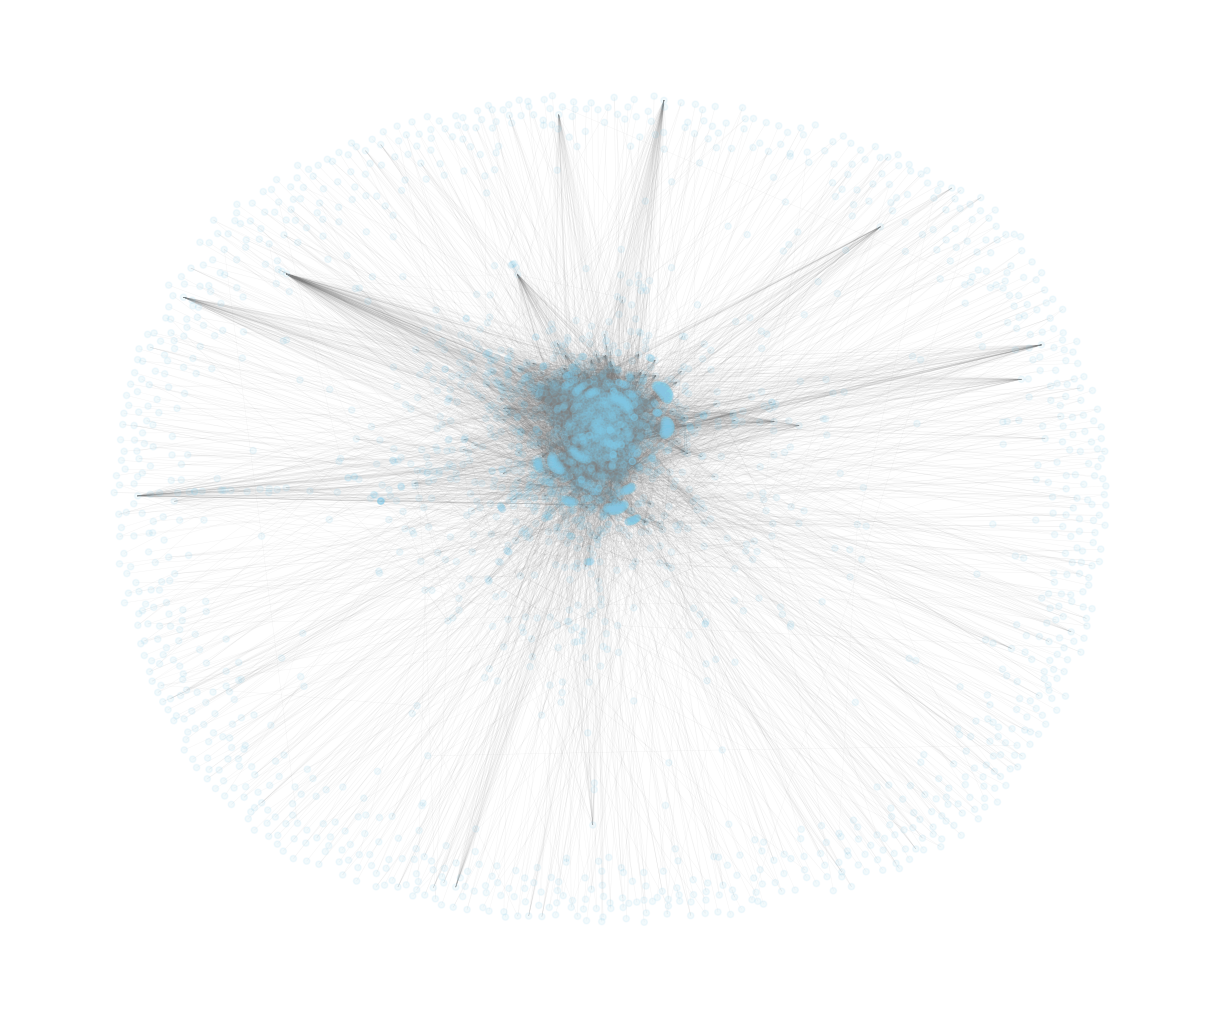

In [ ]:
plot_graph(dict_graph[0])

Building meta-graph
Metagraph is a Graph with 32 nodes and 434 edges


100%|██████████| 32/32 [00:07<00:00,  4.46it/s]


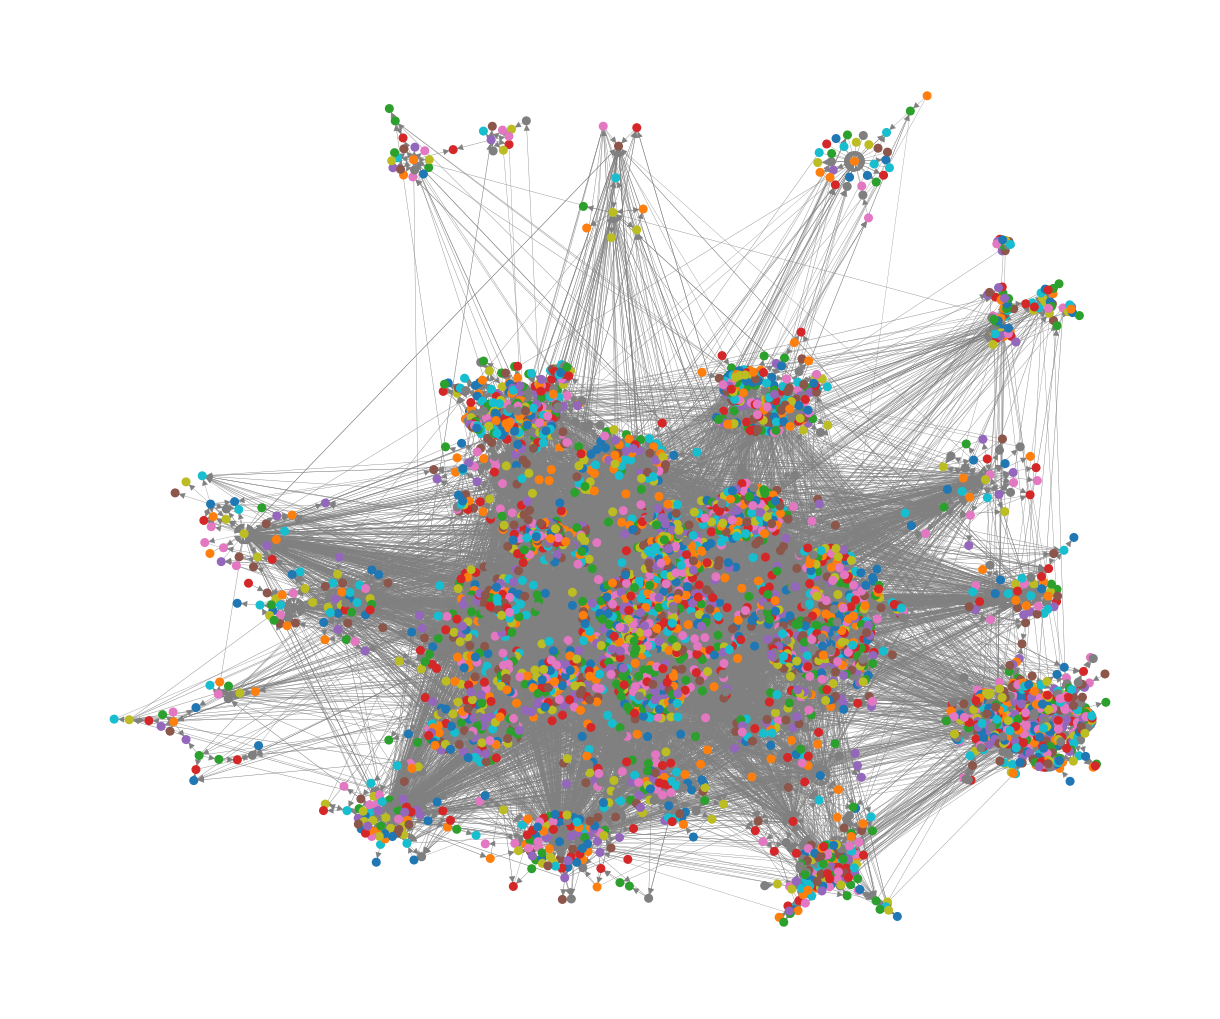

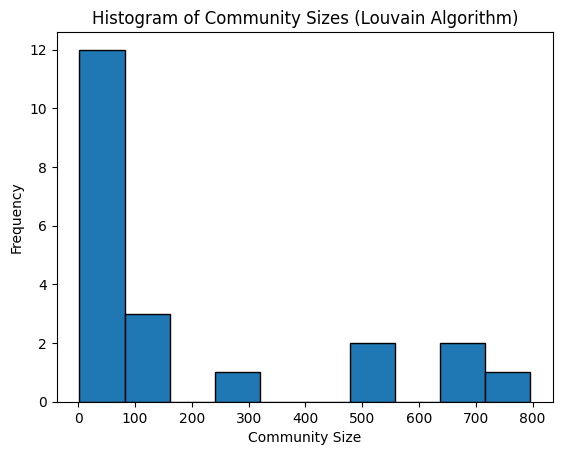

In [ ]:
communities=plot_graph_with_community(dict_graph[0],community_method="louvain")

In [ ]:
nx.write_gexf(dict_graph[0], "graphID0_all.gexf")

In [ ]:
communities_louvain,communities_girvan_newman,communities_label,betweenness=find_comunities(dict_graph)

# Temporal Analysis

In [ ]:
def temporal_community_detection(input_graph, interval_size, unique_dates,step, community_detection_method="l"):
    """
    community_detection_method :
        l : Louvain
        gn : girvan_newman
        cnm : Clauset-Newman-Moore greedy moularity method

        NOTE : Louvain is the only one that seems to work, the other ones run indefinitely
    """
    communities_over_time = []

    # Get the list of unique dates in the graph
    # unique_dates = sorted(set(edge[2]['date'] for edge in graph.edges(data=True)))
    # print(unique_dates)

    # Iterate over time intervals
    for i in tqdm(range(0, (len(unique_dates) - interval_size)//step+1)): #(range(0, len(unique_dates), interval_size)
        graph = input_graph.copy()
        start_date = unique_dates[i+i*(step-1)]
        print(start_date)
        # we do -1 because we also get the transaction of the start day as well, so the start day counts already as 1 day of the total interval_size
        if (i + interval_size - 1) < len(unique_dates):
            end_date = unique_dates[i + interval_size - 1+i*(step-1)]
        else:
            end_date = unique_dates[-1]

        print(end_date)
        # print(f"start : {start_date}\nend : {end_date}")
        # print(f"edge examples : {list(graph.edges(data=True))[:5]}")
        # remove edges outside of time interval
        edges_to_remove = []
        for edge in graph.edges(data=True):
            if (edge[2]["date"] < start_date) or (edge[2]["date"] > end_date):
                edges_to_remove.append((edge[0], edge[1]))
        for rm_edge in edges_to_remove:
            graph.remove_edge(rm_edge[0], rm_edge[1])

        isolated_nodes = list(nx.isolates(graph))

        graph.remove_nodes_from(isolated_nodes)

        # # remove isolated nodes
        # nodes_to_remove = list(nx.isolates(graph))
        # for node in nodes_to_remove:
        #     graph.remove_node(node)

        # nodes_to_keep = []
        # _ = [nodes_to_keep.extend(edge[:2]) for edge in graph.edges(data=True) if start_date <= edge[2]['date'] <= end_date]
        # nodes_to_keep = list(set(nodes_to_keep))
        # # get subgraph of current time interval nodes
        # subgraph = nx.DiGraph(graph.subgraph(nodes_to_keep)) #edge for edge in graph.edges(data=True) if start_date <= edge[2]['date'] <= end_date

        # # get subgraph of current time interval edges
        # edges_to_remove = [(source, target) for source, target, data in subgraph.edges(data=True) if not start_date <= data['date'] <= end_date]


        # subgraph = nx.DiGraph(subgraph.remove_edges_from(edges_to_remove))
        # # graph.subgraph(
        # #     (source, target) for source, target, data in graph.edges(data=True)
        # #     if start_date <= data['date'] <= end_date
        # # )

        # print(f"The tuples we will use : {[(source, target) for source, target, data in graph.edges(data=True) if start_date <= data['date'] <= end_date]}")

        # print(f"The obtained subgraph :")
        # graph_info(graph)
        # print(f"edge examples after cleaning : {list(graph.edges(data=True))[:5]}")

        # community detection
        if community_detection_method == "gn":
            communities = nx.community.girvan_newman(graph.to_undirected())
        elif community_detection_method == "cnm":
            communities = nx.community.greedy_modularity_communities(graph.to_undirected())
        elif community_detection_method == "l":
            communities = nx.community.label_propagation.louvain_communities(graph.to_undirected())

        # print(communities)
        # test = []
        # for j, comm in tqdm(enumerate(communities)):
        #     for _ in comm:
        #         test.append(j)
        # for i, community in enumerate(test):
        #     print(i, community)
        # test = [i for i, community in enumerate(communities) for _ in community]
        # for i, community in enumerate(test):
        #     print(i, community)

        communities_list = list(communities)

        # for i, comm in enumerate(communities_list):
        #     print(f"Community {i + 1}: {comm}")

        # save detected communities
        communities_over_time.append((start_date, end_date, communities_list,isolated_nodes))

        # return

    return communities_over_time

In [ ]:
# interval in days
interval_size = 1 #30
communities_over_time = temporal_community_detection(graph, interval_size, unique_dates[:14],step=7,community_detection_method="l")

for start_date, end_date, communities,_ in communities_over_time:
    print(f"Communities for {start_date} to {end_date}: {communities}")

  0%|          | 0/2 [00:00<?, ?it/s]

2015-01-01
2015-01-01


 50%|█████     | 1/2 [00:44<00:44, 44.23s/it]

2015-01-08
2015-01-08


100%|██████████| 2/2 [01:28<00:00, 44.29s/it]


Communities for 2015-01-01 to 2015-01-01: [{'1144', '47309', '269', '70482234', '17566139', '154', '69303601', '11582', '70717806', 'MeXBT.com', 'ePay.info_CoinJoinMess', 'SatoshiMines.com', '72969555', '5914784', '73179434', '4673', '175', '3073', '17989012', '1422856', '8121566', '289', '4050', '255398', '33728444', '3048834', '2010811', '6216423', '69487117', '70481436', '2682096', '42093257', '1149', 'Xapo.com', '62046790', 'Cex.io', '72367415', '31951990', '72861567', 'Peerbet.org', '74278567', '7675245', 'CoinCafe.com', '43366', 'Coin.mx', '366342', 'NitrogenSports.eu', 'Coinichiwa.com', '536', 'CoinChimp.com', 'Kraken.com', '73022114', 'Bter.com', '143516', 'Exchanging.ir', 'Rollin.io', '348', 'AllCoin.com', '1328107', '70638358', '19396424', '70744026', '149405', 'BitcoinWeBank.com', '0', '986814', 'MaiCoin.com', '69769', '3980', '69958594', '68873411', 'MercadoBitcoin.com.br', '3918', '3120', 'Banx.io', '1233363', 'NucleusMarket', '1226', '1443066', '71163099', '70979323', '70

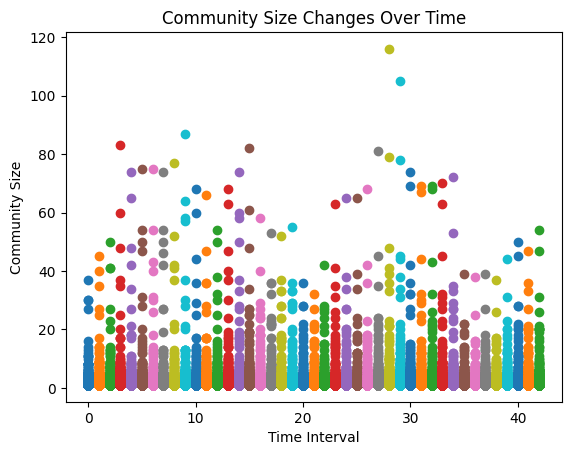

In [ ]:
# community sizes evolution
community_sizes_over_time = []
for _, _, communities_list in communities_over_time:
    community_sizes = [len(community) for community in communities_list]
    community_sizes_over_time.append(community_sizes)

for i, community_sizes in enumerate(community_sizes_over_time):
    plt.plot([i] * len(community_sizes), community_sizes, 'o', label=f'Time Interval {i + 1}')

plt.xlabel('Time Interval')
plt.ylabel('Community Size')
plt.title('Community Size Changes Over Time')
# plt.legend()
plt.show()

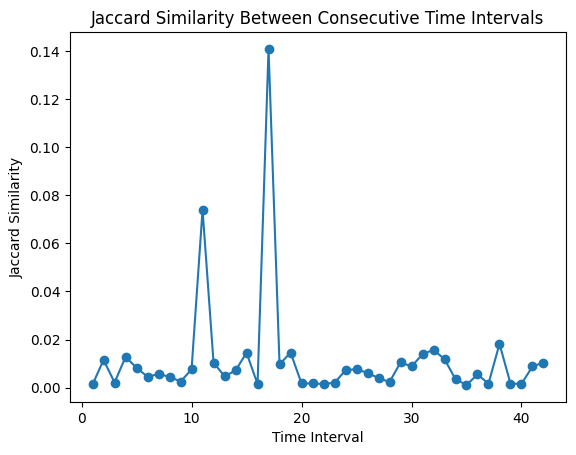

In [ ]:
jaccard_similarity = []
for i in range(len(communities_over_time) - 1):
    communities_a = communities_over_time[i][2]
    communities_b = communities_over_time[i + 1][2]

    # print(f"communities before flatten : {communities_a}")
    # Flatten communities to binary vectors
    binary_communities_a = np.concatenate([np.ones(len(comm)) * idx for idx, comm in enumerate(communities_a)])
    binary_communities_b = np.concatenate([np.ones(len(comm)) * idx for idx, comm in enumerate(communities_b)])
    # print(f"communities after flatten : {binary_communities_a}")
    # print(len(binary_communities_a), len(binary_communities_b))
    # jaccard similarity
    similarity = jaccard_score(binary_communities_a, binary_communities_b, average='micro')
    jaccard_similarity.append(similarity)

plt.plot(range(1, len(communities_over_time)), jaccard_similarity, 'o-')
plt.xlabel('Time Interval')
plt.ylabel('Jaccard Similarity')
plt.title('Jaccard Similarity Between Time Intervals')
plt.show()

In [ ]:
# compare to price of bitcoin

# test stuff

In [ ]:
G = nx.DiGraph()
G.add_edges_from([(1, 2, {'weight': 3}), (2, 3, {'weight': 5}), (3, 1, {'weight': 2}), (4, 5, {'weight': 5})])

# Remove all edges with weight equal to 5
edges_to_remove = [(u, v) for u, v, data in G.edges(data=True) if 'weight' in data and data['weight'] == 5]
G.remove_edges_from(edges_to_remove)

# Print the resulting graph
print(G.edges(data=True))

[(1, 2, {'weight': 3}), (3, 1, {'weight': 2})]


In [ ]:
data_path = "/content/drive/MyDrive/Master/M2 France/Data Mining/Project/data/data/data/networks/"

# empty directed graph
graph_test = nx.DiGraph()

for file_name in tqdm(os.listdir(data_path)[:2]):
    # get file name and date
    file_path = os.path.join(data_path, file_name)
    date = file_path.split('/')[-1][:-4]
    # load file
    df = pd.read_csv(file_path)


    # adding nodes and edges to the graph
    for index, row in df.iterrows():
        the_source = row['Source']
        the_target = row['Target']
        value = row['value']
        nb_transactions = row['nb_transactions']
        # print(f"the source : {the_source}\nthe target : {the_target}")

        # add node (wont be added if already in graph)
        graph_test.add_node(the_source)
        graph_test.add_node(the_target)

        # Add directed edge from source to target
        graph_test.add_edge(the_source, the_target, value=value, nb_transactions=nb_transactions, date=date)


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


In [ ]:
G = nx.DiGraph()
G.add_edges_from([(1, 2, {'date': '2015-01-01'}), (2, 3, {'date': '2015-01-02'}), (3, 1, {'date': '2015-01-03'}), (4, 5, {'date': '2015-01-04'})])

# # Remove all edges with weight equal to 5
# edges_to_remove = [(u, v) for u, v, data in G.edges(data=True) if 'weight' in data and data['weight'] == 5]
# G.remove_edges_from(edges_to_remove)

# # Print the resulting graph
# print(G.edges(data=True))

print("nodes :", G.nodes)
print("edges :", G.edges)
edges_to_remove = []
for edge in G.edges(data=True):
    if (edge[2]["date"] < '2015-01-02') or (edge[2]["date"] > '2015-01-03'):
        print(f"to remove : {(edge[0], edge[1])}")
        edges_to_remove.append((edge[0], edge[1]))

for rm_edge in edges_to_remove:
    G.remove_edge(rm_edge[0], rm_edge[1])

graph_info(G)
print(G.edges)
print(G.nodes)
print(list(nx.isolates(G)))
for node in list(nx.isolates(G)):
    G.remove_node(node)
print(G.nodes)
print(list(nx.isolates(G)))

nodes : [1, 2, 3, 4, 5]
edges : [(1, 2), (2, 3), (3, 1), (4, 5)]
to remove : (1, 2)
to remove : (4, 5)
Type : <class 'networkx.classes.digraph.DiGraph'>
Number of nodes : 5
Number of edges : 2
[(2, 3), (3, 1)]
[1, 2, 3, 4, 5]
[4, 5]
[1, 2, 3]
[]
